In [23]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import noisereduce as nr
import pywt
import warnings
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import jiwer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import time
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np
import jiwer

warnings.filterwarnings('ignore')


In [24]:
SAMPLE_RATE = 16000
N_MFCC = 13
N_MELS = 22
WINDOW = int(SAMPLE_RATE * 0.01)
HOP = int(SAMPLE_RATE * 0.005)
COMMANDS = ["baca", "berhenti", "foto", "halo", "info", "kembali", "ulang"]


In [25]:
def load_audio(file_path, sr=SAMPLE_RATE):
    audio, _ = librosa.load(file_path, sr=sr)
    return audio / np.max(np.abs(audio))

def reduce_noise(audio):
    return nr.reduce_noise(y=audio, sr=SAMPLE_RATE)

def preprocess_audio(file_path):
    audio = load_audio(file_path)
    return reduce_noise(audio)

def wavelet_transform(signal):
    wp = pywt.WaveletPacket(signal, wavelet='db4', mode='symmetric', maxlevel=3)
    return np.concatenate([n.data for n in wp.get_level(3, 'freq')])

def extract_mfcc(signal):
    return librosa.feature.mfcc(
        y=wavelet_transform(signal),
        sr=SAMPLE_RATE,
        n_mfcc=N_MFCC,
        n_mels=N_MELS,
        n_fft=WINDOW,
        hop_length=HOP
    ).T


In [26]:
def load_dataset(directory, commands):
    data = []
    for label in commands:
        folder = os.path.join(directory, label)
        for file in os.listdir(folder):
            if file.endswith('.wav'):
                data.append((os.path.join(folder, file), label))
    return pd.DataFrame(data, columns=["speech", "label"])


In [27]:
def extract_features(df):
    print("Preprocessing and extracting features...")
    features = Parallel(n_jobs=-1)(
        delayed(lambda path: extract_mfcc(preprocess_audio(path)))(fp)
        for fp in tqdm(df['speech'], desc="Extracting")
    )
    df['mfcc'] = features
    return df


In [28]:
def encode_and_pad(df_train, df_valid):
    le = LabelEncoder()
    df_train['label_encoded'] = le.fit_transform(df_train['label'])
    df_valid['label_encoded'] = le.transform(df_valid['label'])

    all_mfcc = df_train['mfcc'].tolist() + df_valid['mfcc'].tolist()
    max_len = max(len(x) for x in all_mfcc)

    X_train = pad_sequences(df_train['mfcc'], maxlen=max_len, padding='post', dtype='float32')
    X_valid = pad_sequences(df_valid['mfcc'], maxlen=max_len, padding='post', dtype='float32')

    y_train = to_categorical(df_train['label_encoded'])
    y_valid = to_categorical(df_valid['label_encoded'])

    return X_train, y_train, X_valid, y_valid, le


In [29]:
def build_model(input_shape, num_classes):
    model = Sequential([
        Masking(mask_value=0.0, input_shape=input_shape),
        LSTM(128, return_sequences=True),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [30]:
def train_model(model, X_train, y_train, X_valid, y_valid, batch_size=32, epochs=100):
    early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )
    return model, history


In [31]:
def evaluate_model(model, X_valid, y_valid, label_encoder):
    # Mulai timer
    start = time.time()
    
    # Predict
    y_pred_probs = model.predict(X_valid)
    end = time.time()
    
    # Konversi ke kelas
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_valid, axis=1)
    
    # Classification Report
    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))
    
    # RTF (Real Time Factor) - asumsi 16 kHz
    audio_duration_total = (X_valid.shape[0] * X_valid.shape[1]) / 16000
    rtf = (end - start) / audio_duration_total
    print(f"RTF (Real Time Factor): {rtf:.4f}")
    
    # Precision, Recall, F1 Score (weighted)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    
    return {
        'RTF': rtf,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'y_true': y_true,
        'y_pred': y_pred_classes
    }


In [32]:
# Load datasets
df_train = load_dataset("augdata/training", COMMANDS)
df_valid = load_dataset("augdata/validation", COMMANDS)

In [33]:
# Preprocessing + Feature extraction
df_train = extract_features(df_train)
df_valid = extract_features(df_valid)


Preprocessing and extracting features...


Extracting: 100%|██████████| 11562/11562 [02:22<00:00, 81.12it/s]


Preprocessing and extracting features...


Extracting: 100%|██████████| 1290/1290 [00:14<00:00, 91.53it/s]


In [34]:
# Encode & pad
X_train, y_train, X_valid, y_valid, le = encode_and_pad(df_train, df_valid)

In [35]:
# Build model
model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=y_train.shape[1])

In [36]:
# Train model
model, history = train_model(model, X_train, y_train, X_valid, y_valid)

Epoch 1/100
362/362 [==============================] - 80s 197ms/step - loss: 1.6682 - accuracy: 0.2951 - val_loss: 1.3098 - val_accuracy: 0.4318
Epoch 2/100
362/362 [==============================] - 76s 210ms/step - loss: 1.1846 - accuracy: 0.4745 - val_loss: 1.0239 - val_accuracy: 0.5380
Epoch 3/100
362/362 [==============================] - 75s 207ms/step - loss: 0.9853 - accuracy: 0.5570 - val_loss: 0.8144 - val_accuracy: 0.6186
Epoch 4/100
362/362 [==============================] - 83s 228ms/step - loss: 0.7909 - accuracy: 0.6728 - val_loss: 0.5727 - val_accuracy: 0.7674
Epoch 5/100
362/362 [==============================] - 75s 208ms/step - loss: 0.5941 - accuracy: 0.7810 - val_loss: 0.4965 - val_accuracy: 0.8163
Epoch 6/100
362/362 [==============================] - 77s 214ms/step - loss: 0.4418 - accuracy: 0.8460 - val_loss: 0.3270 - val_accuracy: 0.8853
Epoch 7/100
362/362 [==============================] - 75s 208ms/step - loss: 0.3506 - accuracy: 0.8825 - val_loss: 0.2735 -

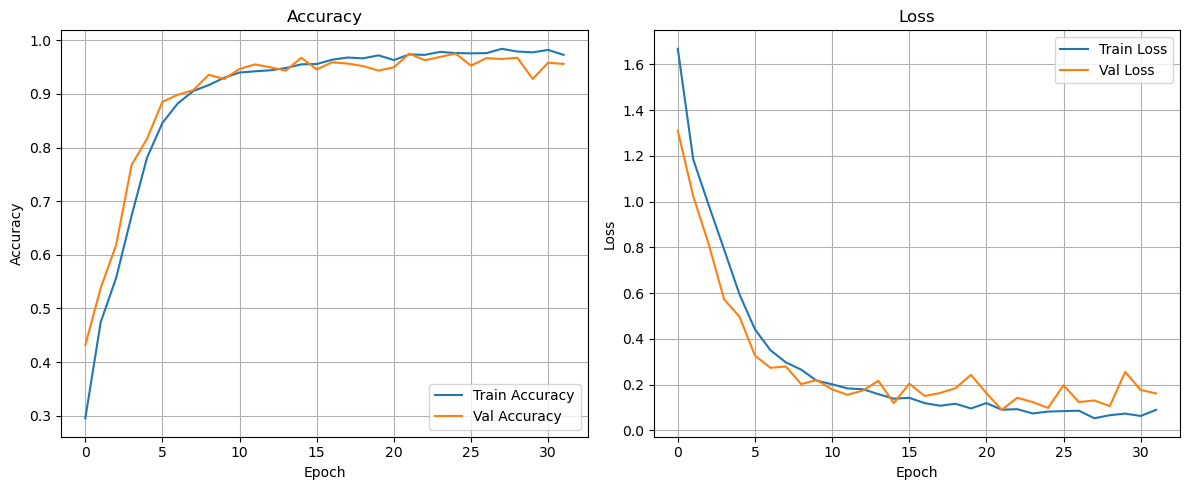

In [37]:
# Grafik akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
# plt.axvline(best_epoch-1, color='r', linestyle='--', label='Best Epoch')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Grafik loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
# plt.axvline(best_epoch-1, color='r', linestyle='--', label='Best Epoch')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [38]:
#Evaluasi
metrics = evaluate_model(model, X_valid, y_valid, le)


41/41 [==============================] - 6s 79ms/step

=== Classification Report ===
              precision    recall  f1-score   support

        baca       0.99      0.97      0.98       184
    berhenti       0.97      0.99      0.98       184
        foto       0.95      0.98      0.97       184
        halo       1.00      0.95      0.97       183
        info       0.99      0.97      0.98       183
     kembali       0.95      0.99      0.97       188
       ulang       0.97      0.98      0.98       184

    accuracy                           0.98      1290
   macro avg       0.98      0.98      0.98      1290
weighted avg       0.98      0.98      0.98      1290

RTF (Real Time Factor): 0.0811
Precision (weighted): 0.9757
Recall (weighted): 0.9752
F1 Score (weighted): 0.9752


In [39]:
model.save('model/mymodele3.h5')

In [40]:
df_train['label'].value_counts()

label
kembali     1680
ulang       1656
baca        1650
foto        1650
berhenti    1644
info        1644
halo        1638
Name: count, dtype: int64

In [41]:
df_valid['label'].value_counts()

label
kembali     188
baca        184
berhenti    184
foto        184
ulang       184
halo        183
info        183
Name: count, dtype: int64

In [42]:
# val_accuracy terbaik
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1  
print(f"Val accuracy terbaik: {best_val_acc:.4f} pada epoch ke-{best_epoch}")

Val accuracy terbaik: 0.9752 pada epoch ke-22


In [43]:
df_train['label_encoded']

0        0
1        0
2        0
3        0
4        0
        ..
11557    6
11558    6
11559    6
11560    6
11561    6
Name: label_encoded, Length: 11562, dtype: int32

In [44]:
# Print the encoding assignment
for label, encoded in zip(le.classes_, range(len(le.classes_))):
    print(f"'{label}' -> {encoded}")

'baca' -> 0
'berhenti' -> 1
'foto' -> 2
'halo' -> 3
'info' -> 4
'kembali' -> 5
'ulang' -> 6


In [1]:
model.summary()

NameError: name 'model' is not defined